## Using SAS DLPy to Create a Neural Network Model for Binary Classification Using Tabular Data

You can use SAS DLPy to easily create and train a variety of basic task-oriented deep learning models. This notebook example shows how you can use SAS DLPy to build a neural network model for a binary classification task using tabular data. 

The clean tabular data used to create the model is the [Scikit-Learn breast cancer data set](https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-wisconsin-diagnostic-dataset). The breast cancer data is a toy data set, a 569-observation table of 30 cellular attribute measurements  from the [UCI ML Breast Cancer Wisconsin (Diagnostic) data sets](https://goo.gl/U2Uwz2). The Wisconsin diagnostic breast cancer data is also available to the public via the University of Wisconsin CS ftp server at `ftp.cs.wisc.edu cd math-prog/cpo-dataset/machine-learn/WDBC/`.

Each anonymized observation in the diagnostic tabular data contains 30 attribute measurements that were computed from digitized images of fine needle aspirates (FNA) of individual breast masses. Each attribute describes characteristics of the cell nuclei present in the image. The two target classes for each observation containing cellular attribute observations are `benign` (target=1) and `malignant` (target=0). More technical information about the composition and use of the Scikit-learn breast cancer data [is available here](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#).

The example in this notebook follows these steps: 

- Configure SAS DLPy and SAS CAS environments for this task.
- Upload the toy diagnostic data set to the SAS CAS server.
- Create train and test data sets in SAS CAS.
- Use SAS DLPy to build a fully-connected neural network classification model.
- Train the fully-connected neural network model.
- Use the trained model to score the test data set.
- Evaluate model performance using a series of analytic model plots.

This tutorial example assumes that you have SAS DLPy API installed, have an active SAS CAS server, and have installed the common Python utilities used in the code (numpy, sklearn, matplotlib, Pandas).

### Table of Contents 
- [Prepare Resources and Configure Environment for Modeling](#getReady)
    - [Import Required Python and SAS DLPy Utilities](#importPythonDLPy)
- [Configure SAS SWAT and Launch SAS CAS](#launchCAS)
- [Load the Example Data](#loadData)
    - [Partition into Train and Test Data](#partitionData)
- [Use SAS DLPy to Create a Neural Network Model](#createModel)
- [Train the Neural Network Classification Model](#trainModel)
- [Score the Test Data Using Trained Neural Network Model](#scoreModel)
- [Examine Neural Network Classification Model Performance Plots](#Plots)    
    - [Evaluate the Confusion Matrix](#confusionMatrix)
    - [Calculate the Model's Predictive Accuracy](#predAccuracy)
    - [Assess ROC Curve and Calculate AUC](#rocAUC)
    - [Evaluate Precision-Recall Curve](#precisionRecall)
    - [Evaluate Average Precision and F1 Scores](#f1Average)
- [Summary](#summary)    


<a id = "getReady"></a>

### Prepare Resources and Configure Computing Environment for Modeling

Use this section to organize all of the resources you need and configure your local computing environment in advance, so you can follow along with the example notebook modeling operations without interruption. 

<a id="importPythonDLPy"></a>

#### Import Required Python and SAS DLPy Utilities

Use this section to import the Python utility libraries and SAS DLPy libraries that will be used for the fully-connected feedforward neural network classification model. 

Import the Python and SAS DLPy utilities required for the model task. They include the scikit-Learn utility, the pandas data analysis library, the numPy scientific computing library, and the matplotlib plotting utility.

In [1]:
# Pandas data analysis utility
import pandas as pd

# NumPy scientific computing utility
import numpy as np

# Import scikit-Learn utility
import sklearn

# Matplotlib plotting utility
import matplotlib.pylab as plt

# SAS DLPy model utilities
from dlpy import Model, Sequential
from dlpy.model import Optimizer, AdamSolver
from dlpy.layers import * 
from dlpy.splitting import two_way_split
from dlpy.metrics import *

# Display output plots in notebook cells
%matplotlib inline

<a id="launchCAS"></a>

### Configure SAS SWAT and Launch SAS CAS

The following code configures SAS SWAT and launches SAS CAS. SWAT is a Python interface to SAS CAS that enables you to load data into memory and apply CAS actions to the data.

<b>Note:</b> For more information about starting a CAS session with the SWAT package, see https://sassoftware.github.io/python-swat/getting-started.html.

In [2]:
# Import SAS SWAT
from swat import *

# SWAT data message handler
import swat.cas.datamsghandlers as dmh

# Configure CAS session for Analytics
s = CAS('your-host-name.unx.company-name.com', 5570)

<a id="loadData"></a>

### Load the Example Data

Use the code block below to import the toy diagnostic data set, create pandas predictor and target dataframes, and then merge the two dataframes. Browse the concatenated pandas table before loading it into SAS CAS.

In [3]:
# Import toy diagnostic breast cancer 
# data from the sci-kit Learn library
# (sklearn package version >= 0.24.1)
from sklearn.datasets import load_breast_cancer 

# load the breast cancer data into SAS CAS and
# save the CAS table as bc_data.
bc_data = load_breast_cancer() 

# Put the bc_data contents into two pandas dataframes: 

# One dataframe for the predictors (bc_x_df). 
bc_x_df = pd.DataFrame(bc_data['data'], columns=bc_data['feature_names'])

# One dataframe for the target (bc_y_df). 
bc_y_df = pd.DataFrame(bc_data['target'], columns=['target_class'])

# Concatenate the predictor and target dataframes 
# into one dataframe with 30 feature columns and 
# 1 target column.
bc_df = pd.concat([bc_x_df, bc_y_df], axis=1)

In [4]:
# Browse the concatenated pandas diagnostic data.
# Display column headings and 10 rows from the table.
bc_df.loc[:9]

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target_class
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0
5,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,...,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,0
6,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,0.05742,...,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,0
7,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,0.07451,...,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510,0
8,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,0.2350,0.07389,...,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720,0
9,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,0.2030,0.08243,...,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750,0


In the table above, the rightmost column `target_class` represents the observation's classification status: a value of 1 indicates a `benign` tumor, and a value of 0 indicates a `malignant` tumor. What is the distribution of `malignant` and `benign` classes in the diagnostic data table of 569 observations?  

Use the `target_class.value_counts()` function to count the two class values in table `bc_df`:

In [5]:
# Show distribution of target values
# for benign and malignant classes 
# in the toy diagnostic data.
bc_df.target_class.value_counts()

1    357
0    212
Name: target_class, dtype: int64

The output shows that 357 of the observations in the table `bc_df` indicate benign tumors (target = '1' in the data), and 212 of the observations indicate malignant tumors (target = '0' in the data). 

Use the `upload_frame()` function with the concatenated table `bc_df` to load the pandas dataframe to the server. The CAS table `bc_df` is loaded and saved in Python as `big_tbl`.

In [6]:
# Load the concatenated data frame bc_df
# to the CAS server and save as big_tbl.
big_tbl = s.upload_frame(bc_df, 
                         casout=dict(name='bc_df', 
                                     replace=True
                                     )
                        )

NOTE: Cloud Analytic Services made the uploaded file available as table BC_DF in caslib CASUSER(UserID).
NOTE: The table BC_DF has been created in caslib CASUSER(UserID) from binary data uploaded to Cloud Analytic Services.


In [7]:
# Show CAS session tables
s.table.tableInfo()

,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,...,Repeated,View,MultiPart,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime
0,BC_DF,569,31,0,utf-8,2021-03-10T16:01:03-05:00,2021-03-10T16:01:03-05:00,2021-03-10T16:01:03-05:00,UTF8,1.931029e+09,...,0,0,0,,,0,UserID,,2021-03-10T16:01:03-05:00,1.931029e+09


<a id="partitionData"></a>

### Partition into Train and Test Data

Split the loaded diagnostic table `big_tbl` into train and test partitions. Use the DLPy `two_way_split` function to perform random server-side sampling and partition the data into `train_tbl` and `test_tbl`. Server-side partitioning is preferable to client-side partitioning when the data is large, or when the data is already on the server. 

The code below partitions 70% of `big_tbl` into `train_tbl`, and the remaining 30% is partitioned as `test_tbl`. The `seed` value is specified to ensure repeatability of example computation results.

In [8]:
# Partition big_tbl into train and test data sets
train_tbl, test_tbl = two_way_split(big_tbl, 
                                    # 30% test partition
                                    test_rate=30, 
                                    seed=5309, 
                                    # random sampling without stratification
                                    stratify=False, 
                                    # using tabular numeric data,
                                    # not an image table
                                    im_table=False)

In [9]:
# Display five rows from the train table.
train_tbl.head()


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target_class
0,16.130,20.68,108.10,798.8,0.11700,0.20220,0.17220,0.10280,0.2164,0.07356,...,31.48,136.80,1315.0,0.1789,0.4233,0.47840,0.20730,0.3706,0.11420,0.0
1,13.540,14.36,87.46,566.3,0.09779,0.08129,0.06664,0.04781,0.1885,0.05766,...,19.26,99.70,711.2,0.1440,0.1773,0.23900,0.12880,0.2977,0.07259,1.0
2,9.504,12.44,60.34,273.9,0.10240,0.06492,0.02956,0.02076,0.1815,0.06905,...,15.66,65.13,314.9,0.1324,0.1148,0.08867,0.06227,0.2450,0.07773,1.0
3,15.340,14.26,102.50,704.4,0.10730,0.21350,0.20770,0.09756,0.2521,0.07032,...,19.08,125.10,980.9,0.1390,0.5954,0.63050,0.23930,0.4667,0.09946,0.0
4,16.650,21.38,110.00,904.6,0.11210,0.14570,0.15250,0.09170,0.1995,0.06330,...,31.56,177.00,2215.0,0.1805,0.3578,0.46950,0.20950,0.3613,0.09564,0.0


In [10]:
# Display five rows from the test table.
test_tbl.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target_class
0,19.81,22.15,130.00,1260.0,0.09831,0.1027,0.14790,0.09498,0.1582,0.05395,...,30.88,186.80,2398.0,0.1512,0.3150,0.5372,0.23880,0.2768,0.07615,0.0
1,13.08,15.71,85.63,520.0,0.10750,0.1270,0.04568,0.03110,0.1967,0.06811,...,20.49,96.09,630.5,0.1312,0.2776,0.1890,0.07283,0.3184,0.08183,1.0
2,21.16,23.04,137.20,1404.0,0.09428,0.1022,0.10970,0.08632,0.1769,0.05278,...,35.59,188.00,2615.0,0.1401,0.2600,0.3155,0.20090,0.2822,0.07526,0.0
3,17.14,16.40,116.00,912.7,0.11860,0.2276,0.22290,0.14010,0.3040,0.07413,...,21.40,152.40,1461.0,0.1545,0.3949,0.3853,0.25500,0.4066,0.10590,0.0
4,14.58,21.53,97.41,644.8,0.10540,0.1868,0.14250,0.08783,0.2252,0.06924,...,33.21,122.40,896.9,0.1525,0.6643,0.5539,0.27010,0.4264,0.12750,0.0


<a id="createModel"></a>

### Use SAS DLPy to Create a Fully-Connected Neural Network Model

Use SAS DLPy to create a fully-connected feed-forward neural network binary classification model with the following architecture: 

- one dense layer
- 20 neurons
- `relu` activation layer
- `softmax` output layer activation function
- `entropy` output layer loss function 
- 2 neurons (classes) in the output layer.

Save the newly created model in Python as `model1`, and save the model table in SAS CAS as `simple_dnn_classifier`.

In [11]:
# Create fully-connected deep neural network 'model1'
model1 = Sequential(s, 
                    model_table=CASTable('simple_dnn_classifier', 
                                         replace=True
                                        )
                   )
# Input layer
model1.add(InputLayer(std='STD'))

# Dense layer
model1.add(Dense(20, act='relu'))

# Output layer
model1.add(OutputLayer(act='softmax', 
                       n=2,  
                       error='entropy'
                       )
           )

NOTE: Input layer added.
NOTE: Fully-connected layer added.
NOTE: Output layer added.
NOTE: Model compiled successfully.


As an additional exercise, uncomment the bottom line of the code below, and run the cell to generate a DAG of `model1`.

In [ ]:
# Generate a DAG for the simple
# neural network classification model

#model1.plot_network()

The generated DAG for the simple neural network classification model should resemble the following:

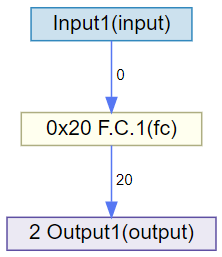

<a id="trainModel"></a>

### Train the Neural Network Classification Model

Now use `fit()` with `model1` to train the fully-connected neural network model using a scheduled training approach with the following hyperparameter specifications:

- `AdamSolver` optimizer to show a scheduled training approach
- `learning_rate_policy='step'` to specify a stepwise learning rate decreasing policy
- `step_size=5` to multiply the `learning_rate` by factor `gamma=0.9` every 5 epochs
- `log_level=2` to view the training log
- `seed=5309` to support model determinism and repeatable results.

Save the trained model table in Python as `result`.

In [12]:
# Specify optimizer settings for scheduled training approach
# These optimizer settings are called in the fit() block that 
# follows.
optimizer = Optimizer(algorithm=AdamSolver(learning_rate=0.005, 
                                           learning_rate_policy='step', 
                                           gamma=0.9, 
                                           step_size=5), 
                      mini_batch_size=4, 
                      seed=5309,
                      max_epochs=50, 
                      log_level=2)

# Train the model model1 using 
# data train_tbl, and save the  
# trained output table as 'result' 
result = model1.fit(train_tbl, 
                    inputs=bc_x_df.columns.tolist(), 
                    nominals=['target_class'], 
                    target='target_class', 
                    optimizer=optimizer
                    )

NOTE: Training from scratch.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 662.
NOTE:  The approximate memory cost is 1.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       0.01 (s).
NOTE:  The total number of threads on each worker is 32.
NOTE:  The maximum mini-batch size per thread on each worker is 4.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 128.
NOTE:  Target variable: target_class
NOTE:  Number of levels for the target variable:      2
NOTE:  Levels for the target variable:
NOTE:  Level      0:            0
NOTE:  Level      1:            1
NOTE:  Number of input variables:    30
NOTE:  Number of numeric input variables:     30
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  0         0.005          0.9199     0.6543     0.01
NOTE:  1         0.005          0.4822     0.1699     0.00
NOTE:  2         0.005          0.3232     0.1172     0.00
NOTE:  3 

Use the matplotlib function `plot_training_history()` with `model1` to display a graph of the model's training over 50 epochs:

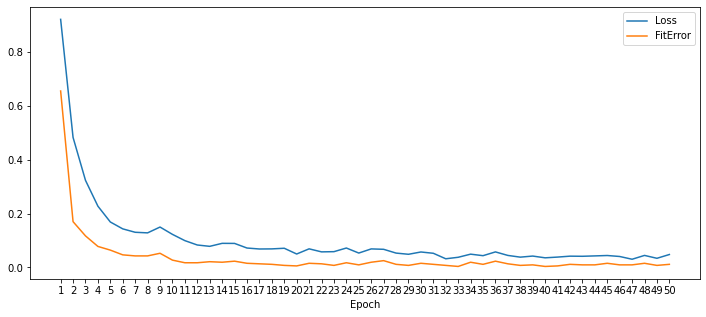

In [13]:
# Plot the training history of 'model1' to
# display the changing model loss and fit 
# error values over 50 epochs.
model1.plot_training_history()

<a id="scoreModel"></a>

### Score the Test Data Using Trained Neural Network Model

Now use the `predict()` function for `model1` with `test_tbl` to score the test data. Save the scored data in `model1.valid_res_tbl` in Python as `test_result_table`.

In [14]:
# Use model1 to score the test data test_tbl.
test_result = model1.predict(test_tbl)
# Save the scored data table as test_result_table.
test_result_table = model1.valid_res_tbl

NOTE: Due to data distribution, miniBatchSize has been limited to 6.


Use the `head()` function to show the first five rows of the scored `test_result_table`. The rightmost column `_DL_PredLevel` contains the scored binary predictions for each observation: 0.0 (malignant) or 1.0 (benign).

In [15]:
# Display the first five rows of 
# the scored test data that was 
# saved as test_result_table.
test_result_table.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target_class,P_target_class0,P_target_class1,I_target_class,_DL_PredP_,_DL_PredLevel_
0,19.81,22.15,130.00,1260.0,0.09831,0.1027,0.14790,0.09498,0.1582,0.05395,...,0.5372,0.23880,0.2768,0.07615,0.0,1.000000,5.168375e-09,0,1.000000,0.0
1,13.08,15.71,85.63,520.0,0.10750,0.1270,0.04568,0.03110,0.1967,0.06811,...,0.1890,0.07283,0.3184,0.08183,1.0,0.005913,9.940871e-01,1,0.994087,1.0
2,21.16,23.04,137.20,1404.0,0.09428,0.1022,0.10970,0.08632,0.1769,0.05278,...,0.3155,0.20090,0.2822,0.07526,0.0,1.000000,1.909779e-08,0,1.000000,0.0
3,17.14,16.40,116.00,912.7,0.11860,0.2276,0.22290,0.14010,0.3040,0.07413,...,0.3853,0.25500,0.4066,0.10590,0.0,1.000000,4.672073e-07,0,1.000000,0.0
4,14.58,21.53,97.41,644.8,0.10540,0.1868,0.14250,0.08783,0.2252,0.06924,...,0.5539,0.27010,0.4264,0.12750,0.0,0.999959,4.144951e-05,0,0.999959,0.0


Note that the rightmost column in the scored test table is the predicted binary target classifier, `_DL_PredLevel_`.  

<a id="Plots"></a>

### Examine Neural Network Classification Model Performance Plots

Now we can use a variety of scored model metrics to assess the performance of the neural network binary classification model `model1`. In this section we use the scored data to calculate the model confusion matrix, the model accuracy score, the ROC curve, the area under ROC curve (AUC), the Precision-Recall curve, and the model's F1 score.

<a id="confusionMatrix"></a>

#### Evaluate the Confusion Matrix

First, show the confusion matrix for the model1 scored data in test_result_table. The confusion matrix is a performance measurement for deep learning classification models. The confusion matrix for a binary classification problem is a 2 x 2 table that shows a summary of the model's predicted values versus actual ground truth values.

In [16]:
# Show the confusion matrix for the scored table
display(confusion_matrix(test_result_table['target_class'], 
                         test_result_table['I_target_class']
                         )
        )

,0,1
target_class,,
0.0,59.0,3.0
1.0,2.0,107.0


The row headings `0.0` and `1.0` represent the target classes `malignant` and `benign`. The confusion matrix shows that out of the scored data, there were 59 true positives, and 3 false positives for target class 0 `malignant`. There were also 2 false negatives, and 107 true negatives for target class 1 `benign`. In other words, out of 171 scored test observations, 166 were correctly classified, and 5 were incorrectly classified.

<a id="predAccuracy"></a>

#### Calculate the Model's Predictive Accuracy
Based on the test data set score, what is the model's predictive accuracy? Use the `accuracy_score()` function to create the output table `acc_score`, and use the `print()` function to display it. 

In multilabel classification, the accuracy function computes subset accuracy for predicted and ground truth labels. Accuracy scores range from 0 to 1. Model accuracy score values that are very close to 1 indicate higher model accuracy.

In [17]:
# Calculate the accuracy score
acc_score = accuracy_score(test_result_table['target_class'], 
                           test_result_table['I_target_class']
                           )
print('The accuracy score for the test data is {:.6f}.'.format(acc_score))

The accuracy score for the test data is 0.970760.


<a id="rocAUC"></a>

#### Assess ROC Curve and Calculate AUC

As another performance measure, use the scored test results in `test_result_table` with the `plot_roc()` function to generate a plot of the ROC curve for the `benign` target class where `target_class=1`. The ROC curve is a graphical plot that illustrates the performance of a binary classification system as its discrimination threshold is varied.

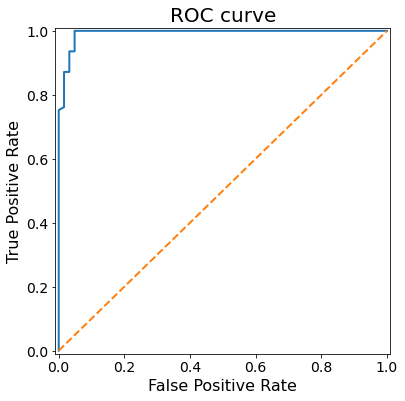

In [18]:
# Plot the ROC curve for target_class = 1. 
plot_roc(test_result_table['target_class'], 
         test_result_table['P_target_class1'], 
         pos_label=1, 
         figsize=(6,6), 
         linewidth=2
         )

The ROC curve rises aggressively towards the ideal predictor's perfect true positive rate of (1,0). This is a strong ROC curve.

Now use the SAS DLPy function `roc_auc_score()` with the scored test table `test_result_table` with `P_target_class1` to calculate the AUC, the area under the ROC curve.

AUC, or the area under the ROC curve, is a performance measurement for the classification model at various threshold settings. The ROC is a probability curve. The AUC represents the degree of separability. AUC indicates how well the model performs in distinguishing between classes. The score is a value between 0.0 and 1.0, with a value of 1.0 being a perfect classifier. The closer to 1 the AUC score is, the better the model performs at predicting 0s as 0s and 1s as 1s. 

In [19]:
# Calculate the AUC, or Area under the ROC curve.
# Save the resulting Python table as auc_of_roc.
auc_of_roc = roc_auc_score(test_result_table['target_class'], 
                           test_result_table['P_target_class1'], 
                           pos_label=1
                           )
print('The AUC area under the ROC curve for the scored test data is {:.6f}.'.format(auc_of_roc))

The AUC area under the ROC curve for the scored test data is 0.992971.


<a id="precisionRecall"></a>

#### Evaluate Precision-Recall Curve

Now use the function `plot_precision_recall()` with the scored test table `test_result_table` and `P_target_class1` to generate the Precision-Recall curve for target class 1.

Precision is a metric that quantifies the number of correct positive predictions that were made. It is calculated as the number of true positives divided by the total number of true positives and false positives. The result is a value between 0.0 for no precision and 1.0 for full or perfect precision.

Recall is a metric that describes the number of correct positive predictions made out of all positive predictions that could have been made. It is calculated as the number of true positives divided by the total number of true positives and false negatives. In other words, recall represents the true positive rate. The result is a value between 0.0 for no recall and 1.0 for perfect recall.

A Precision-Recall curve is a plot of the precision (y-axis) and the recall (x-axis) for different probability thresholds. 

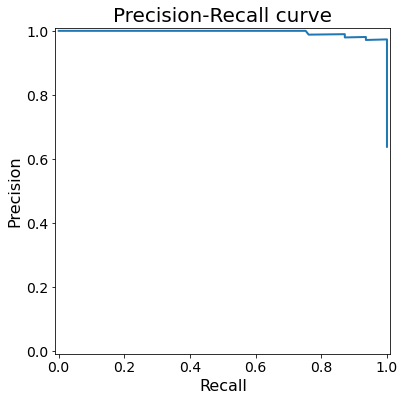

In [20]:
# Plot the precision recall curve for target_class = 1. 
plot_precision_recall(test_result_table['target_class'], 
                      test_result_table['P_target_class1'], 
                      pos_label=1, 
                      figsize=(6,6), 
                      linewidth=2
                      )

The plotted precision-recall curve bows heavily towards the perfect skill coordinate at (1,1). A classification model with poor or no skill would be a horizontal line on the plot. This is a good precision-recall curve for the model.


<a id="f1Average"></a>

#### Evaluate Average Precision Score and F1 Score

Now use the function `average_precision_score()` with the scored test table `test_result_table` and `P_target_class1` to calculate the model's average precision score for target class 1. For a binary classification task, average precision summarizes a Precision-Recall curve as the weighted mean of precisions achieved at each threshold. The increase in recall from the previous threshold becomes the weight. Average precision scores range from 0 to 1. The closer the score is to 1, the better the precision of the model.

In [21]:
# Calculate the average precision score
ap = average_precision_score(test_result_table['target_class'], 
                             test_result_table['P_target_class1'], 
                             pos_label=1
                             )
print('The average precision score for the scored test data is {:.6f}.'.format(ap))

The average precision score for the scored test data is 0.995637.


The average precision score for this binary classification model is 0.995637, indicating strong model precision.

Finally, use the function `f1_score()` with the scored test table `test_result_table` and `I_target_class` to calculate the F1 score for target class 1. The F1 score represents a weighted average of the scoring model's precision and recall. The best score for an F1 value is 1, and the worst score is 0. The influences of precision and recall on the f1 score are equal.

The closer the F1 score is to 1.0, the greater the model performance.

In [22]:
# Calculate the F1 score
f1sc = f1_score(test_result_table['target_class'], 
                test_result_table['I_target_class'], 
                pos_label=1
                )
print('The F1 score for the scored test data is {:.6f}.'.format(f1sc))

The F1 score for the scored test data is 0.977169.


The F1 score for the neural network binary classification model is 0.977169, very close to 1.0. This is a high f1 score, indicative of a high-performing predictive classification model.

<a id="summary"></a>

### Summary

It is relatively easy to create and modify task-centric models using SAS DLPy. This example showed how to use SAS DLPy to create a fully-connected feedforward neural network model for a binary classification task using tabular data. It showed how to use DLPy to score data with a trained model, and it also showed how to use DLPy to generate and view multiple performance metrics (ROC, AUC, Precision-Recall curve, Average Precision score, and F1 score) using scored data table output from the trained neural network model.